# Numerical simulations presented in "Comment on "Harvesting information to control non-equilibrium states of active matter" (ArXiv:2212.06825)

We import libraries and numerical integration scripts:

In [1]:
import numpy as np
import scipy.signal as sig
import matplotlib.pyplot as plt

from Numerical_Simulations_Langevin_Equation import colored_noise_simu
from Numerical_Simulations_Langevin_Equation import Brownian_simu

For more information about the numerical integration scripts uncomment the following:

In [2]:
#help(colored_noise_simu)
#help(Brownian_simu)

We define the spectral entropy:

In [3]:
def spectral_entropy(S):
    S_norm = S/np.sum(S)
    H_S = - np.sum(S_norm*np.log(S_norm))
    return H_S

## 1) Verification that the colored noises are correctly simulated

We generate 100 samples of colored noises with different cut-off frequencies, and verify that they have the expected variance and Power Spectral Density (PSD):

Cut-off frequency = 100.0 Hz
Variance of the simulated colored noise = 0.9857617453660827
Corresponding integral of the simulated PSD = 0.9873243601745326
Cut-off frequency = 500.0 Hz
Variance of the simulated colored noise = 0.9876634164782203
Corresponding integral of the simulated PSD = 0.9955280876292132
Cut-off frequency = 1000.0 Hz
Variance of the simulated colored noise = 0.9876645665731509
Corresponding integral of the simulated PSD = 0.9960668729564899
Cut-off frequency = 5000.0 Hz
Variance of the simulated colored noise = 0.9614318657756578
Corresponding integral of the simulated PSD = 0.9704466152017729


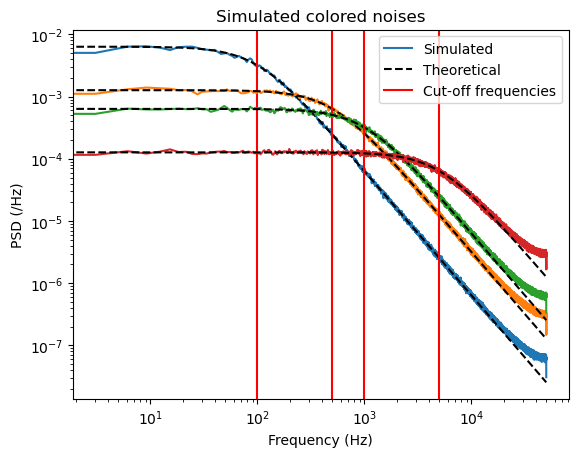

In [4]:
n_traj=100
duree=1 #s
dt=1e-5 #s

N_spectre=2**15 #number of points for the computation of the power spectrum with Welch's method

alpha=1 #variance of the colored noises
fcs=[1e2,5e2,1e3,5e3] #cut-off frequencies for the colored noises

for i_freq in range(len(fcs)):

    fc = fcs[i_freq]    

    noise = colored_noise_simu(n_traj=n_traj,dt=dt,duration=duree,alpha=alpha,fc=fc)
    
    f,spectrums=sig.welch(noise,1/dt, window='hann', nperseg=N_spectre)
    
    plt.loglog(f,np.mean(spectrums,0),label="Simulated PSD")
    plt.loglog(f,(4*(2*np.pi*fc)*alpha/((2*np.pi*f)**2+(2*np.pi*fc)**2)),'k--',label="Theoretical PSD")
    plt.axvline(fc, color='red',label="Cut-off frequencies")
    
    var_noise =np.var(noise,0)
    
    print('Cut-off frequency = {} Hz'.format(fc))
    print('Variance of the simulated colored noise = {}'.format(np.mean(var_noise)))
    print('Corresponding integral of the simulated PSD = {}'.format(np.sum(np.mean(spectrums,0))*np.mean(np.diff(f))))

plt.title('Simulated colored noises')
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD (/Hz)')
plt.legend(['Simulated','Theoretical','Cut-off frequencies'])

All the colored noises simulated all have the expected variance and PSD.

## 2) Verification that the Brownian trajectories are correctly simulated

We simulate 100 trajectories of a Brownian particle held in an optical trap (quadratic potential) and submitted to a colored noise that was generated above:

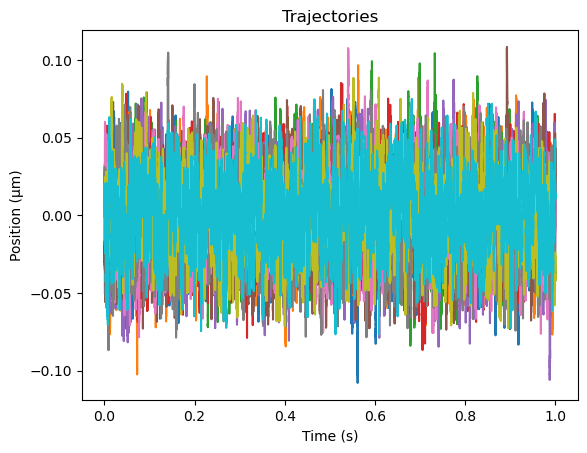

In [5]:
#Parameters
nb_part=100
duration=1 #s
dt=1e-5 #s

radius=1.5e-6 #m
viscosity=1e-3 #Pa.s
stiffness=25e-6 #optical trap stiffness (N/m)
k_B=1.381e-23 #J/K
temperature=298.15 #K

F_cut = 1000 #cut-off frequency of the colored noise (Hz)
Ca = 10000 #amplification of the colored noise (Da = Ca*D, with D the equilibrium diffusion coefficient of the particle)

#External forces

#Spring like force from the optical trap:
def F_ext(x):
    return -stiffness*x

gamma = 6*np.pi*viscosity*radius
nb_time_increment=int(np.round(duration/dt))

#Colored external noise:
colored_noise=np.sqrt(Ca*2*gamma*k_B*temperature)*colored_noise_simu(n_traj=nb_part,dt=dt,duration=duration,alpha=1,fc=F_cut)

#Simulation:
traj_x,time = Brownian_simu(nb_part=nb_part,duration=duration,dt=dt,r=radius,eta=viscosity,k_B=k_B,T=temperature,ext_F=F_ext,ext_noise=colored_noise,on_plot=True)

We verify that the position PSD corresponds to the theoretical prediction:

Text(0, 0.5, 'PSD (m²/Hz)')

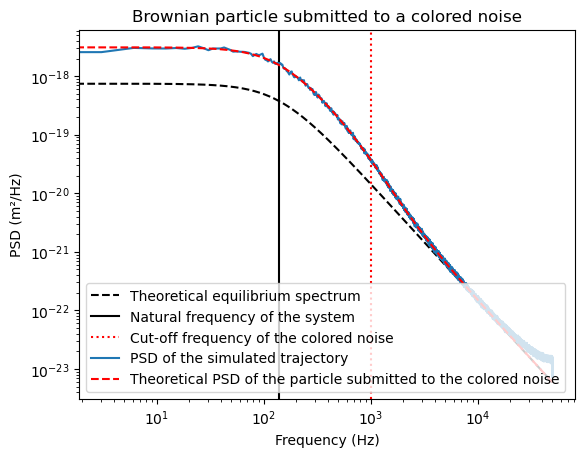

In [6]:
N_spectre=2**15 #number of points for the computation of the power spectrum with Welch's method

w0 = stiffness/gamma
f0 = w0/(2*np.pi) #natural frequency of the Brownian particle in the optical trap
wc = 2*np.pi*F_cut
D=k_B*temperature/gamma #equilibrium diffusion coefficient of the particle
Da=Ca*D #amplitude of the colored noise

f,spectrums=sig.welch(traj_x,1/dt, window='hann', nperseg=N_spectre)

plt.figure()
plt.loglog(f,(4*D/((2*np.pi*f)**2+(2*np.pi*f0)**2)),'k--',label="Theoretical equilibrium spectrum")
plt.axvline(f0, color='black',label="Natural frequency of the system")
plt.axvline(F_cut, color="red",linestyle='dotted',label="Cut-off frequency of the colored noise")
plt.loglog(f,np.mean(spectrums,0),label="PSD of the simulated trajectory")
plt.loglog(f,2/((2*np.pi*f)**2+(w0)**2)*(2*D+(4*Da*wc/((wc)**2+(2*np.pi*f)**2))),'r--',label="Theoretical PSD of the particle submitted to the colored noise")
plt.legend(loc="lower left")
plt.title('Brownian particle submitted to a colored noise')
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD (m²/Hz)')

We verify that the variance corresponds to the theoretical prediction:

In [7]:
var_exp=np.var(traj_x,1)
print('Variance of the simulated trajectory = {} m²'.format(np.mean(var_exp)))
print('Integral of the corresponding PSD = {} m²'.format(np.sum(np.mean(spectrums,0))*np.mean(np.diff(f))))
print('Theoretical variance of the particle submitted to the colored noise = {} m²'.format(D/w0 + 2*Da/(w0*(w0+wc))))
print('Theoretical variance if the particle was at equilibrium = {} m²'.format(k_B*temperature/stiffness))
print('Equivalent temperature = {} K'.format(np.mean(var_exp)*stiffness/k_B))

Variance of the simulated trajectory = 6.233240773761332e-16 m²
Integral of the corresponding PSD = 6.213078025329032e-16 m²
Theoretical variance of the particle submitted to the colored noise = 6.242748453031164e-16 m²
Theoretical variance if the particle was at equilibrium = 1.6469805999999997e-16 m²
Equivalent temperature = 1128.3926092978515 K


## 3) Example of "STEP Protocol" where the color of the noise is changed in the middle of the trajectory

We simulate 1000 trajectories of a Brownian particle held in a optical trap and submitted to a colored noise that is suddenly changed from $\eta_1$ (with $f_c$ = 500 Hz) to $\eta_2$ (with $f_c$ = 50 Hz) after 0.5s:

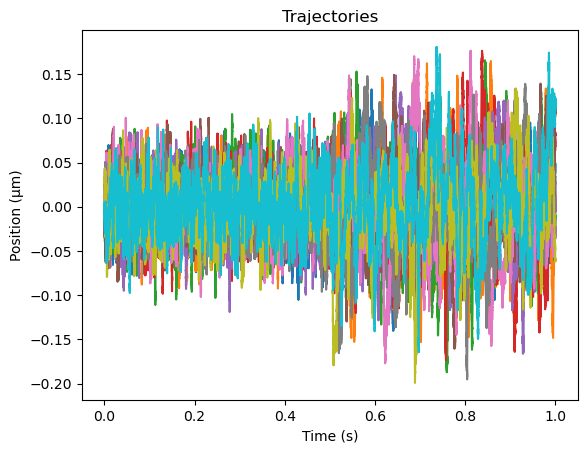

In [8]:
#Cut-off frequencies of the two noises
F_cut_1=500 #Hz
F_cut_2=50 #Hz

#Numerical parameters
nb_part=1000
duration=1 #s
dt=1e-5 #s

#Physical parameters
radius=1.5*1e-6 #m
viscosity=1e-3 #Pa.s
stiffness=25*1e-6 #optical trap stiffness N/m
k_B=1.381e-23 #J/K
temperature=298.15 #K
Ca = 10000 # #amplification of the colored noise (Da = Ca*D, with D the equilibrium diffusion coefficient of the particle)

#External forces

#Spring like force from the optical trap:
def F_ext(x):
    return -stiffness*x

gamma = 6*np.pi*viscosity*radius
nb_time_increment=int(np.round(duration/dt))

#Colored noise, that is switched in the middle of the trajectory
colored_noise_1=np.sqrt(Ca*2*gamma*k_B*temperature)*colored_noise_simu(n_traj=nb_part,dt=dt,duration=duration,alpha=1,fc=F_cut_1)
colored_noise_2=np.sqrt(Ca*2*gamma*k_B*temperature)*colored_noise_simu(n_traj=nb_part,dt=dt,duration=duration,alpha=1,fc=F_cut_2)

colored_noise=np.empty_like(colored_noise_1)
colored_noise[:,0:int(nb_time_increment/2)]=colored_noise_1[:,0:int(nb_time_increment/2)]
colored_noise[:,int(nb_time_increment/2):]=colored_noise_2[:,int(nb_time_increment/2):]

#Simulation:
traj_x,time = Brownian_simu(nb_part=nb_part,duration=duration,dt=dt,r=radius,eta=viscosity,k_B=k_B,T=temperature,ext_F=F_ext,ext_noise=colored_noise,on_plot=True)

As expected, the variance of the trajectories changes at t = 0.5 s, when the noise is switched from $\eta_1$ (with $f_c$ = 200 Hz) to $\eta_2$ (with $f_c$ = 50 Hz).

To better see the effect of changing the colored noise, we plot the ensemble variance of the 1000 trajectories as a function of time:

(1.0, 1000.0, 0.0005, 0.004)

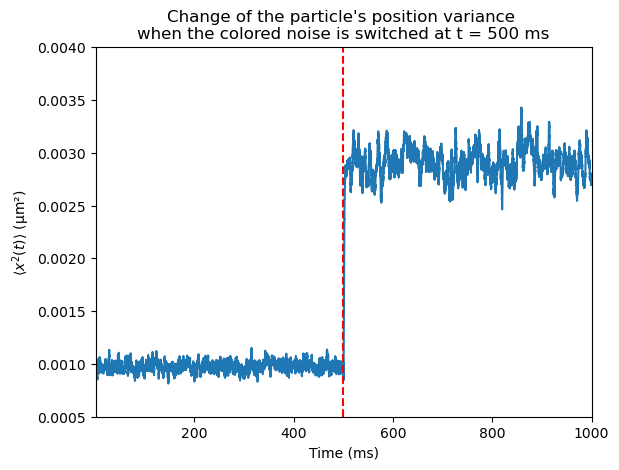

In [9]:
variance=np.var(traj_x,0)

plt.figure()
plt.plot(time*1e3,variance*1e12)
plt.axvline(x=(duration/2)*1e3,color='red',linestyle='dashed')
plt.title('Change of the particle\'s position variance \nwhen the colored noise is switched at t = 500 ms')
plt.xlabel('Time (ms)')
plt.ylabel(r'$\langle x^2(t) \rangle$ (µm²)')
plt.axis([1,1000,0.0005,0.004])

We can also plot the PSD of the particle's position, in the first NESS (with $\eta_1$) and in the second NESS (with $\eta_2$):

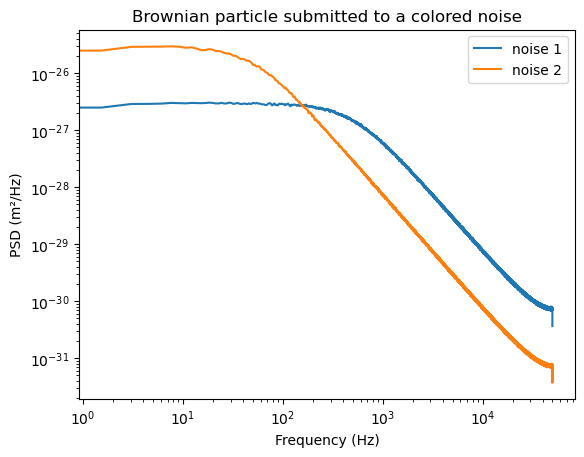

In [10]:
N_spectre=2**16 #number of points for the computation of the power spectrum with Welch's method

f,spectres_1=sig.welch(colored_noise_1,1/dt, window='hann', nperseg=N_spectre)
f,spectres_2=sig.welch(colored_noise_2,1/dt, window='hann', nperseg=N_spectre)

spectre_1=np.mean(spectres_1,0)
spectre_2=np.mean(spectres_2,0)

plt.figure()
plt.loglog(f,spectre_1,label="noise 1")
plt.loglog(f,spectre_2,label="noise 2")
plt.title('Brownian particle submitted to a colored noise')
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD (m²/Hz)')
plt.legend()

Finally, we can compute the heat released $\Delta Q_{EX}$ and the change of spectral entropy $\Delta H_S$:

In [11]:
w0 = stiffness/gamma
f0 = w0/(2*np.pi) #natural frequency of the Brownian particle in the optical trap
wi = 2*np.pi*F_cut_1
wf = 2*np.pi*F_cut_2
D=k_B*temperature/gamma #equilibrium diffusion coefficient of the particle
Da=Ca*D #amplitude of the colored noise

nb_pts_relax=int(2/f0/dt) #Number of points that is required for the particle to reach a NESS after the change of external noise

var_1=np.mean(np.var(traj_x[:,nb_pts_relax:int(nb_time_increment/2)],0))
var_2=np.mean(np.var(traj_x[:,int(nb_time_increment/2)+nb_pts_relax:],0))

HS_1=spectral_entropy(spectre_1)
HS_2=spectral_entropy(spectre_2)

Delta_H = (HS_1-HS_2) #simulated spectral entropy difference
Delta_Qex = 0.5*stiffness*(var_2-var_1) #simulated heat released
Delta_Qex_theo = stiffness*((Da/(w0*(w0+wf)))-(Da/(w0*(w0+wi)))) #theoretical predictions for the heat released

print('Spectral entropy difference = {} (dimensionless)'.format(Delta_H))
print('Simulated heat released = {} (kbT units)'.format(Delta_Qex/(k_B*temperature)))
print('Predicted heat released = {} (kbT units)'.format(Delta_Qex_theo/(k_B*temperature)))

Spectral entropy difference = 2.257507148403894 (dimensionless)
Simulated heat released = 5.861597165503231 (kbT units)
Predicted heat released = 5.860797316183953 (kbT units)


## 4) Computing the released heat and the spectral entropy difference for several STEP Protocols

The following loop simulates several STEP Protocols, where the colored noise is switched from $\eta_1$ (with $f_{c1}$ = 1600 Hz) to $\eta_2$ (with $f_{c2}$ that is varied from 1600 Hz to 50 Hz). For each STEP Protocol, the released heat $\Delta Q_{EX}$ and the spectral entropy difference $\Delta H_S$ are computed.

In [12]:
F_fixe=1600#Hz Cut-off frequency of noise 1
F_change=np.array([50,100,200,500,1000,1250,1400,1600]) #Hz Cut-off frequencies of noise 2 (different noises 2 are tested)

#Numerical parameters
nb_part=1000
duration=1 #s
dt=1e-5 #s

#Physical parameters
radius=1.5*1e-6 #m
viscosity=1e-3 #Pa.s
stiffness=25*1e-6 #optical trap stiffness N/m
k_B=1.381e-23 #J/K
temperature=298.15 #K
Ca = 10000 # #amplification of the colored noise (Da = Ca*D, with D the equilibrium diffusion coefficient of the particle)

#Spring like force from the optical trap:
def F_ext(x):
    return -stiffness*x

gamma = 6*np.pi*viscosity*radius
nb_time_increment=int(np.round(duration/dt))

w0 = stiffness/gamma
f0 = w0/(2*np.pi) #natural frequency of the Brownian particle in the optical trap
D=k_B*temperature/gamma #equilibrium diffusion coefficient of the particle
Da=Ca*D #amplitude of the colored noise

N_spectre=2**16 #number of points for the computation of the power spectrum with Welch's method
nb_pts_relax=int(2/f0/dt) #Number of points that is required for the particle to reach a NESS after the change of external noise

Delta_H=np.zeros(len(F_change))
Delta_Qex=np.zeros(len(F_change))
Delta_Qex_theo=np.zeros(len(F_change))

spectre_fixe=np.zeros(int(N_spectre/2+1))
spectre_change=np.zeros((len(F_change),int(N_spectre/2+1)))

variances=np.zeros((len(F_change),nb_time_increment))

for i_F2 in range(len(F_change)):
    
    print(i_F2)
    
    #Data Simulation:
    
    F_cut_1=F_fixe
    F_cut_2=F_change[i_F2]

    #Colored noise, that is switched in the middle of the trajectory
    colored_noise_1=np.sqrt(Ca*2*gamma*k_B*temperature)*colored_noise_simu(n_traj=nb_part,dt=dt,duration=duration,alpha=1,fc=F_cut_1)
    colored_noise_2=np.sqrt(Ca*2*gamma*k_B*temperature)*colored_noise_simu(n_traj=nb_part,dt=dt,duration=duration,alpha=1,fc=F_cut_2)

    colored_noise=np.empty_like(colored_noise_1)
    colored_noise[:,0:int(nb_time_increment/2)]=colored_noise_1[:,0:int(nb_time_increment/2)]
    colored_noise[:,int(nb_time_increment/2):]=colored_noise_2[:,int(nb_time_increment/2):]

    #Trajectories:
    traj_x,time = Brownian_simu(nb_part=nb_part,duration=duration,dt=dt,r=radius,eta=viscosity,k_B=k_B,T=temperature,ext_F=F_ext,ext_noise=colored_noise,on_plot=False)

    #Data Analysis
    
    variances[i_F2,:]=np.var(traj_x,0)
    var_1=np.mean(np.var(traj_x[:,nb_pts_relax:int(nb_time_increment/2)],0))
    var_2=np.mean(np.var(traj_x[:,int(nb_time_increment/2)+nb_pts_relax:],0))
  
    f,spectres_1=sig.welch(colored_noise_1,1/dt, window='hann', nperseg=N_spectre)
    f,spectres_2=sig.welch(colored_noise_2,1/dt, window='hann', nperseg=N_spectre)

    spectre_1=np.mean(spectres_1,0)
    spectre_2=np.mean(spectres_2,0)
    
    spectre_fixe=spectre_1
    spectre_change[i_F2,:]=spectre_2
    
    HS_1=spectral_entropy(spectre_1)
    HS_2=spectral_entropy(spectre_2)
    
    wi = 2*np.pi*F_cut_1
    wf = 2*np.pi*F_cut_2
    
    Delta_H[i_F2] = (HS_1-HS_2) #simulated spectral entropy difference
    Delta_Qex[i_F2] = 0.5*stiffness*(var_2-var_1) #simulated heat released
    Delta_Qex_theo[i_F2] = stiffness*((Da/(w0*(w0+wf)))-(Da/(w0*(w0+wi)))) #theoretical predictions for the heat released


0
1
2
3
4
5
6
7


We plot the PSD of the particle's position for each colored noise $\eta_2$:

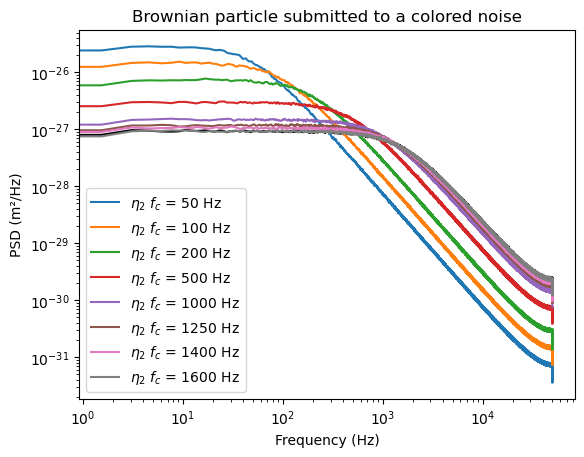

In [13]:
plt.figure()
plt.loglog(f,spectre_fixe,'k')
for i_F2 in range(len(F_change)):
    plt.loglog(f,spectre_change[i_F2,:],label="$\eta_2$ $f_c$ = {} Hz".format(F_change[i_F2]))
plt.title('Brownian particle submitted to a colored noise')
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD (m²/Hz)')
plt.legend()

We plot the particle's position variances, as a function of time, for the different STEP Protocols:

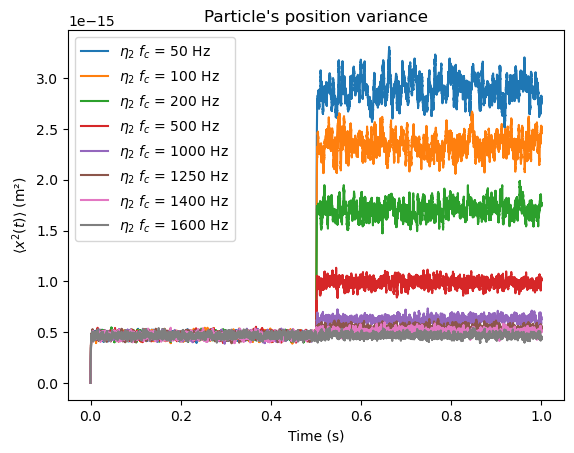

In [14]:
plt.figure()
for i_F2 in range(len(F_change)):
    plt.plot(time,variances[i_F2,:],label="$\eta_2$ $f_c$ = {} Hz".format(F_change[i_F2]))
plt.title('Particle\'s position variance')
plt.xlabel('Time (s)')
plt.ylabel(r'$\langle x^2(t) \rangle$ (m²)')
plt.legend()

We plot the values of $\Delta H_S$ and $\Delta Q_{EX}$ obtained in the simulation, and compare them to the theoretical predictions (Figure 3 in the article):

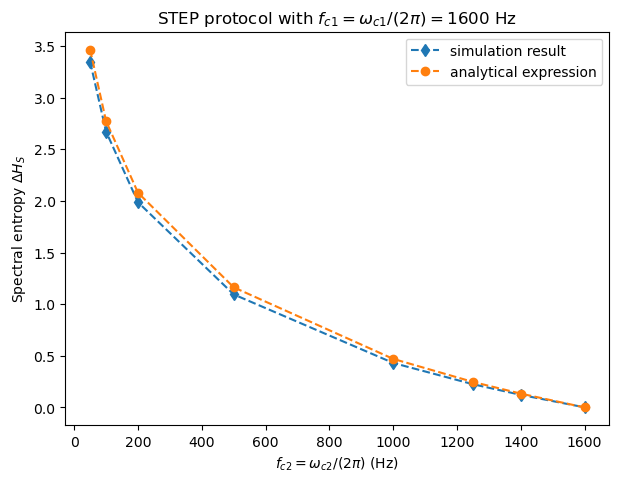

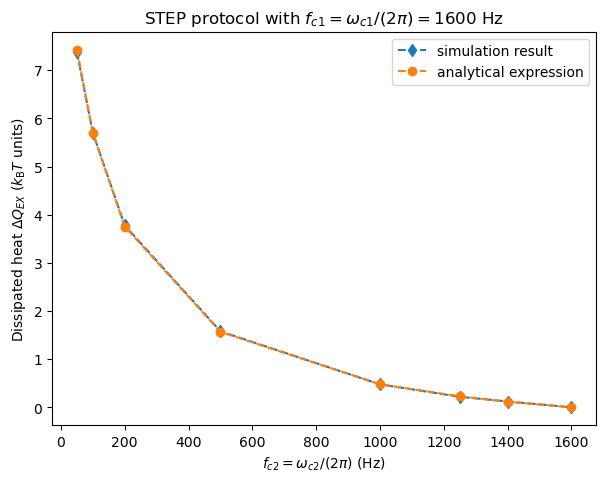

In [15]:
title='{} Hz'.format(F_fixe)

plt.figure()
plt.plot(F_change,Delta_H,'d--',label='simulation result')
plt.plot(F_change,-np.log(F_change/F_fixe),'o--',label='analytical expression')
plt.xlabel(r'$f_{c2} = \omega_{c2}/(2\pi)$ (Hz)')
plt.ylabel(r'Spectral entropy $\Delta H_S$')
plt.title(r'STEP protocol with $f_{c1} = \omega_{c1}/(2\pi) =$'+title)
plt.legend()
plt.subplots_adjust(left=0.12, right=0.97, top=0.94, bottom=0.12)
#plt.savefig('Figure_3a.pdf')

plt.figure()
plt.plot(F_change,Delta_Qex/(k_B*temperature),'d--',label='simulation result')
plt.plot(F_change,Delta_Qex_theo/(k_B*temperature),'o--',label='analytical expression')
plt.xlabel(r'$f_{c2} = \omega_{c2}/(2\pi)$ (Hz)')
plt.ylabel(r'Dissipated heat $\Delta Q_{EX}$ ($k_\mathrm{B}T$ units)')
plt.title(r'STEP protocol with $f_{c1} = \omega_{c1}/(2\pi) =$'+title)
plt.legend()
plt.subplots_adjust(left=0.12, right=0.97, top=0.94, bottom=0.12)
#plt.savefig('Figure_3b.pdf')

## 5) Trying to understand how one can find a linear relation between $\Delta Q_{EX}$ and $\Delta H_S$ (even though it is clear from the analytical and numerical simulations that this is false)

We directly plots $\Delta Q_{EX}$ as a function of $\Delta H_S$. We see that, with this particular graphical representation, it is possible to find a reasonable fit that would give a linear relation between the two quantities (Figure 4a in the article):

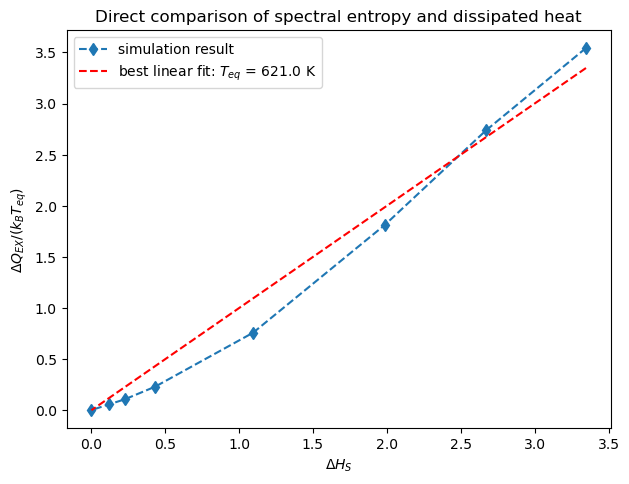

In [16]:
from scipy.optimize import curve_fit

def f_lin(x,a):
   return a*x

popt=curve_fit(f_lin,Delta_H,Delta_Qex/(k_B))

Teq=popt[0][0]

plt.figure()
plt.plot(Delta_H,Delta_Qex/(k_B*Teq),'d--',label='simulation result')
plt.plot(Delta_H,popt[0]*Delta_H/Teq,'r--',label=r'best linear fit: $T_{eq}$ = '+'{:.5} K'.format(Teq))
plt.xlabel(r'$\Delta H_S$')
plt.ylabel(r'$\Delta Q_{EX}/(k_B T_{eq})$')
plt.title('Direct comparison of spectral entropy and dissipated heat')
plt.legend()
plt.subplots_adjust(left=0.12, right=0.97, top=0.94, bottom=0.11)
#plt.savefig('Fig4a.pdf')

However, if we rather plot the ratio $T_{eff} = \frac{\Delta Q_{EX}}{k_B \Delta H_S}$ as a function of $f_{c2}$, it is clear that there is not linear relation between the heat released and the spectral entropy difference (Figure 4b in the article):

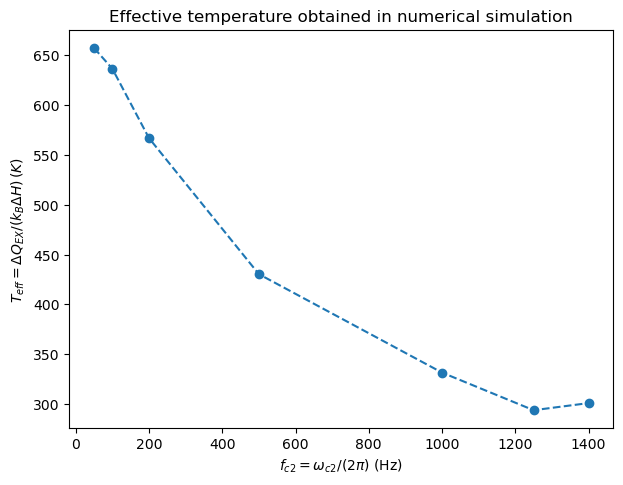

In [17]:
Teff=Delta_Qex/(k_B*Delta_H)

plt.figure()
plt.plot(F_change[:-1],Teff[:-1],'o--')
plt.xlabel(r'$f_{c2} = \omega_{c2}/(2\pi)$ (Hz)')
plt.ylabel(r'$T_{eff}=\Delta Q_{EX}/(k_B\Delta H) \, (K)$')
plt.title('Effective temperature obtained in numerical simulation')
plt.subplots_adjust(left=0.12, right=0.97, top=0.94, bottom=0.11)
#plt.savefig('Fig4b.pdf')

We believe that this is a better way to plot the data, in particular as it that does not rely on the knowledge of $D_a$ (that is unknown in experiments) nor $T_{eq}$ (that is unknown in numerical simulations).